In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

MAX_DEPTH = 20
PROB_BRANCH = 0.25
VALUES = range(1, 10)
OPS_E = [0, 1]
OPS_T = [2, 3]
NTYPES = ['e', 't']
OP_MAP = ['+', '-', '*', '/']

In [7]:
def gen_expr(depth, ntype):
    
    if depth < MAX_DEPTH:
        r = random.random()
    else:
        r = 1 + 0.1
    
    if r > PROB_BRANCH:
        if ntype == 'f':
            value = random.choice(VALUES)
            return value
        elif ntype == 't':
            return gen_expr(depth + 1, 'f')
        elif ntype == 'e':
            return gen_expr(depth + 1, 't')
    
    else:
        if ntype == 'f':
            e = gen_expr(depth + 2, 'e')
            t = [['(', e], ')']
        elif ntype == 't':
            op = random.choice(OPS_T)
            v1, v2 = gen_expr(depth + 2, 't'), gen_expr(depth + 1, 'f')
            t = [[v1, OP_MAP[op]], v2]
        else:
            assert ntype == 'e'
            op = random.choice(OPS_E)
            v1, v2 = gen_expr(depth + 2, 'e'), gen_expr(depth + 1, 't')
            t = [[v1, OP_MAP[op]], v2]
    
    return t

In [8]:
def gen_tree():
    return gen_expr(0, 'e')

In [9]:
def to_value(t):
    if not isinstance(t, list):
        return t

    l = t[0]
    r = t[1]
    if l[1] in OP_MAP:
        v1, op = (to_value(l[0]), l[1])
        v2 = to_value(r)
        return eval(''.join([str(v1), op, str(v2)]))
    else:
        assert l[0] == '('
        v = to_value(l[1])
        return v

In [10]:
def to_nlst(t):
    return list(filter(lambda x: x not in ['[', ']', ',', '\'', ' '], str(t)))

In [11]:
def to_sd(t):
    if not isinstance(t, list):
        d = []
        h = 0
    else:
        l, r = t
        d_l, h_l = to_sd(l)
        d_r, h_r = to_sd(r)
        h = max(h_l, h_r) + 1
        d = d_l + [h] + d_r

    return d, h

In [12]:
def to_value_sd(sd_lst, node_lst):
    if len(sd_lst) == 0:
        node = node_lst[0]
        v = node
    else:
        i = np.argmax(sd_lst)
        child_l, v_l = to_value_sd(sd_lst[:i], node_lst[:i+1])
        child_r, v_r = to_value_sd(sd_lst[i+1:], node_lst[i+1:])
        node = [child_l, child_r]
        if isinstance(v_l, list) and not isinstance(v_r, list):
            if v_l[1] in OP_MAP:
                v1, op = v_l[0], v_l[1]
                v2 = v_r
                v = str(eval(''.join([v1, op, v2])))
            else:
                assert v_l[0] == '('
                v = str(v_l[1])
        else:
            assert not isinstance(v_l, list) and not isinstance(v_r, list)
            v = [v_l, v_r]

    return node, v

In [13]:
def ave_len(es):
    lens = []
    for e in es:
        lens.append(e[0].split())
    return np.average(lens), np.var(lens)

# sanity check

In [18]:
MAX_DEPTH = 30
for _ in range(100):
    expr = gen_expr(0, 'e')
    if expr in VALUES:
        continue

    if expr not in VALUES:
        res = to_nlst(expr)
        gold = eval(''.join(res))
        calc = to_value(expr)
        if gold != calc:
            print(expr, calc, gold)

In [15]:
MAX_DEPTH = 30
for _ in range(100):
    expr = gen_expr(0, 'e')
    if expr in VALUES:
        continue

    if expr not in VALUES:
        node_lst = to_nlst(expr)
        sd_lst, h = to_sd(expr)
        gold = eval(''.join(node_lst))
        t, calc = to_value_sd(sd_lst, node_lst)
        if str(gold) != calc:
            print(expr, calc, gold)

# prob_branch v.s. dist

In [257]:
MAX_DEPTH = 30
PROB_BRANCH = 0.4
NSAMPLES = 100000

In [258]:
examples = []
for _ in range(NSAMPLES):
    t = gen_tree()
    nodes = to_nlst(t)
    nodes = ' '.join(nodes)
    sd_lst, h = to_sd(t)
#     if h > MAX_DEPTH:
#         continue
    if h == 0:
        continue
#     sd_lst = ' '.join([str(sd) for sd in sd_lst])
    sd_lst = ' '.join(list(map(str, sd_lst))) 
    examples.append((nodes, sd_lst, str(h)))

In [259]:
examples[3]

('( ( 6 / ( 2 / ( 1 ) + ( 4 ) * 4 ) * 6 + ( 3 / 2 * ( 8 ) / 8 * 6 ) * 6 + ( ( 2 / 2 / 5 ) ) / 4 / 5 - 2 - ( ( 2 - 3 / 9 ) + 7 ) * 5 - 1 * ( 8 ) / 6 / 8 ) )',
 '24 22 1 8 6 1 3 1 2 4 5 1 2 3 4 7 9 10 11 13 9 1 2 3 4 1 2 5 6 7 8 10 11 12 14 15 7 5 1 2 3 4 6 8 9 10 11 12 16 17 18 19 8 4 1 3 1 2 5 6 7 9 10 11 20 21 1 3 1 2 4 5 6 7 23 25',
 '25')

In [260]:
depths = [int(example[-1]) for example in examples]

(array([11291.,  2055.,  6441.,  2313.,  3859.,  2199.,  2693.,  1879.,
         1908.,  1616.,  1612.,  1366.,  1272.,  1119.,  1098.,   996.,
          974.,   989.,  1034.,  1423.,  2065.,  3114.,  4296.,  5348.,
         5704.,  4888.,  3121.,  1368.,   354.,    34.]),
 array([ 2.        ,  2.96666667,  3.93333333,  4.9       ,  5.86666667,
         6.83333333,  7.8       ,  8.76666667,  9.73333333, 10.7       ,
        11.66666667, 12.63333333, 13.6       , 14.56666667, 15.53333333,
        16.5       , 17.46666667, 18.43333333, 19.4       , 20.36666667,
        21.33333333, 22.3       , 23.26666667, 24.23333333, 25.2       ,
        26.16666667, 27.13333333, 28.1       , 29.06666667, 30.03333333,
        31.        ]),
 <a list of 30 Patch objects>)

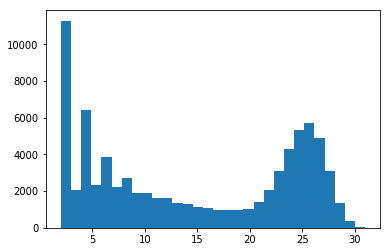

In [261]:
plt.hist(depths, bins=MAX_DEPTH)

(array([2.1293e+04, 2.9350e+03, 9.1120e+03, 2.6880e+03, 4.2000e+03,
        0.0000e+00, 1.8600e+03, 2.0610e+03, 1.1170e+03, 1.0280e+03,
        6.3400e+02, 0.0000e+00, 5.4500e+02, 3.4500e+02, 2.9900e+02,
        1.8800e+02, 1.4600e+02, 0.0000e+00, 1.2900e+02, 8.9000e+01,
        6.3000e+01, 5.2000e+01, 3.4000e+01, 0.0000e+00, 4.7000e+01,
        2.0000e+01, 1.5000e+01, 7.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([ 2.        ,  2.83333333,  3.66666667,  4.5       ,  5.33333333,
         6.16666667,  7.        ,  7.83333333,  8.66666667,  9.5       ,
        10.33333333, 11.16666667, 12.        , 12.83333333, 13.66666667,
        14.5       , 15.33333333, 16.16666667, 17.        , 17.83333333,
        18.66666667, 19.5       , 20.33333333, 21.16666667, 22.        ,
        22.83333333, 23.66666667, 24.5       , 25.33333333, 26.16666667,
        27.        ]),
 <a list of 30 Patch objects>)

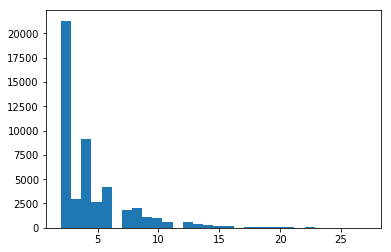

In [11]:
MAX_DEPTH = 30
PROB_BRANCH = 0.2
NSAMPLES = 100000
examples = []
for _ in range(NSAMPLES):
    t = gen_tree()
    nodes = to_nlst(t)
    nodes = ' '.join(nodes)
    sd_lst, h = to_sd(t)
#     if h > MAX_DEPTH:
#         continue
    if h == 0:
        continue
#     sd_lst = ' '.join([str(sd) for sd in sd_lst])
    sd_lst = ' '.join(list(map(str, sd_lst))) 
    examples.append((nodes, sd_lst, str(h)))
depths = [int(example[-1]) for example in examples]
plt.hist(depths, bins=MAX_DEPTH)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

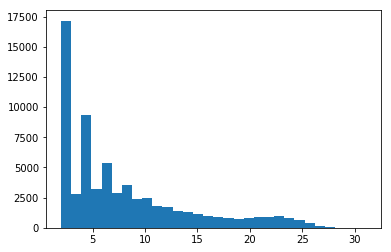

In [14]:
MAX_DEPTH = 30
PROB_BRANCH = 0.3
NSAMPLES = 100000
examples = []
for _ in range(NSAMPLES):
    t = gen_tree()
    nodes = to_nlst(t)
    nodes = ' '.join(nodes)
    sd_lst, h = to_sd(t)
#     if h > MAX_DEPTH:
#         continue
    if h == 0:
        continue
#     sd_lst = ' '.join([str(sd) for sd in sd_lst])
    sd_lst = ' '.join(list(map(str, sd_lst))) 
    examples.append((nodes, sd_lst, str(h)))
depths = [int(example[-1]) for example in examples]
plt.hist(depths, bins=MAX_DEPTH)
print(ave_len(examples))

# generate dataset

In [10]:
from collections import defaultdict

In [11]:
MAX_DEPTH = 30
PROB_BRANCH = 0.4
NSAMPLES = 100000
prob_h = (1/np.array(range(2, MAX_DEPTH+1)) )**(1.5)
prob_h = prob_h / prob_h.sum()
nsamples_bound = {h:int(prob_h[h-2]*NSAMPLES) for h in range(2, MAX_DEPTH+1)}
nsamples = defaultdict(int)

In [12]:
prob_h

array([0.28278739, 0.15392996, 0.09998044, 0.07154018, 0.05442246,
       0.04318749, 0.03534842, 0.02962383, 0.02529327, 0.02192381,
       0.01924124, 0.01706436, 0.01526908, 0.01376791, 0.01249756,
       0.01141121, 0.01047361, 0.00965772, 0.00894252, 0.00831144,
       0.00775124, 0.00725126, 0.00680281, 0.00639875, 0.00603316,
       0.00570111, 0.00539844, 0.00512163, 0.00486769])

In [13]:
nsamples_bound

{2: 28278,
 3: 15392,
 4: 9998,
 5: 7154,
 6: 5442,
 7: 4318,
 8: 3534,
 9: 2962,
 10: 2529,
 11: 2192,
 12: 1924,
 13: 1706,
 14: 1526,
 15: 1376,
 16: 1249,
 17: 1141,
 18: 1047,
 19: 965,
 20: 894,
 21: 831,
 22: 775,
 23: 725,
 24: 680,
 25: 639,
 26: 603,
 27: 570,
 28: 539,
 29: 512,
 30: 486}

In [14]:
examples = []
printed = {h:False for h in range(2, MAX_DEPTH+1)}
i = 0
while True:
    finished = True
    for h in range(2, MAX_DEPTH+1):
        if nsamples[h] < nsamples_bound[h]:
            finished = False
    if finished:
        break
    
    t = gen_tree()
    if t in VALUES:
        continue
    nodes = to_nlst(t)
    nodes = ' '.join(nodes)
    sd_lst, h = to_sd(t)
    if h > MAX_DEPTH:
        continue
    if nsamples[h] >= nsamples_bound[h]:
        if not printed[h]:
            print('finished:', h)
            printed[h] = True
        continue
    else:
        nsamples[h] += 1
    
    sd_lst = ' '.join([str(sd) for sd in sd_lst])
    examples.append((nodes, sd_lst, str(h)))
    i += 1

    if i >= NSAMPLES:
        break

finished: 26
finished: 27
finished: 25
finished: 28
finished: 24
finished: 23
finished: 29
finished: 22
finished: 21
finished: 20
finished: 19
finished: 18
finished: 17
finished: 16
finished: 14
finished: 12
finished: 13
finished: 15
finished: 10
finished: 8
finished: 30
finished: 11
finished: 6
finished: 4
finished: 9
finished: 7
finished: 2
finished: 5


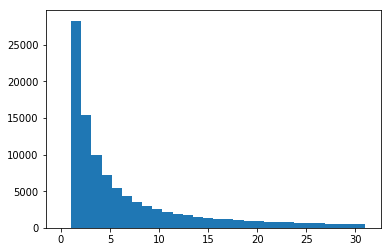

In [15]:
depths = [int(example[-1]) for example in examples]
plt.hist(depths, bins=30, range=(0, MAX_DEPTH+1))
plt.show()

# distribution of sequence length

In [16]:
seq_len = []
for (seq, _, _) in examples:
    seq_len.append(len(seq.split()))

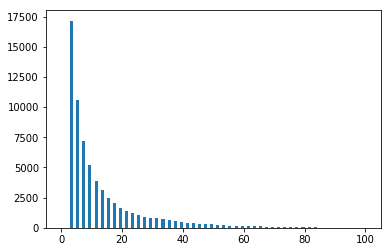

In [18]:
plt.hist(seq_len, bins=100, range=(0, 100))
plt.show()

# similarity between samples under each depth

In [20]:
def ed(s1, s2):
    m=len(s1)+1
    n=len(s2)+1

    tbl = {}
    for i in range(m): tbl[i,0]=i
    for j in range(n): tbl[0,j]=j
    for i in range(1, m):
        for j in range(1, n):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            tbl[i,j] = min(tbl[i, j-1]+1, tbl[i-1, j]+1, tbl[i-1, j-1]+cost)

    return tbl[i,j]

print(ed("Helloworld", "HalloWorld"))

2


In [30]:
examples[0]

('( 2 * ( ( ( 7 + 5 / 8 + ( 7 ) + 1 * 1 + 3 / ( 8 ) * 4 ) / ( 2 ) - ( 6 ) ) ) + 8 )',
 '23 1 20 18 16 10 1 3 1 2 4 5 1 2 6 7 1 2 8 9 1 3 1 2 4 5 11 12 13 1 2 14 15 1 2 17 19 21 22 24',
 '24')

In [31]:
examples[1]

('( 5 )', '1 2', '2')

In [32]:
examples[2]

('( 4 ) + ( 9 / 6 ) * 2', '1 2 3 7 3 1 2 4 5 6', '7')

In [33]:
ed(examples[0][1].split(), examples[2][1].split())

32

In [21]:
def expected_ed(samples, nsampling=1000):
    res = []
    lens = []
    for _ in range(nsampling):
        e1 = random.choice(samples)
        e2 = random.choice(samples)
        edis = ed(e1[1].split(), e2[1].split())
        res.append(edis)
        l1 = len(e1[1].split())
        l2 = len(e2[1].split())
        l_mean = np.mean([l1, l2])
        lens.append(l_mean)
        
    return np.mean(res)/np.mean(lens)

In [42]:
examples_h = {}
for line in examples:
    expr, ds, h = line
    h = int(h)
    if h not in examples_h:
        examples_h[h] = []
    examples_h[h].append((expr, ds))

In [43]:
expr, ds, h = examples[0]

In [46]:
hs = []
expected_eds = []
for h in sorted(examples_h.keys()):
    hs.append(h)
    expected_eds.append(expected_ed(examples_h[h]))

In [37]:
examples_h[2]

[('9 - 1', '1 2')]

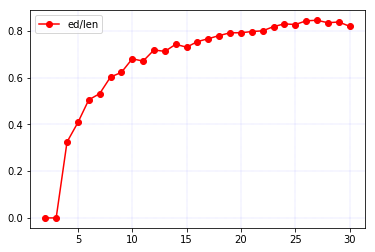

In [47]:
def draw(x, y):
    plt.plot(x, y, 'ro-', label='ed/len')
    plt.legend()
    plt.grid()
    plt.grid(color='b' , linewidth=0.1 ,linestyle='--')
draw(hs, expected_eds)

In [28]:
expected_eds

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

# save

In [49]:
random.shuffle(examples)
ntrain = int(0.8 * NSAMPLES)
nvalid = int(0.1 * NSAMPLES)
ntest = int(0.1 * NSAMPLES)
train = examples[:ntrain]
valid = examples[ntrain: ntrain+nvalid]
test = examples[ntrain+nvalid:]
for dataset, dataset_type in zip([train, valid, test], ['train', 'valid', 'test']):
    with open('%s_d%d.parenthesis.tsv' % (dataset_type, MAX_DEPTH), 'w') as f:
        for line in dataset:
            f.write('\t'.join(line))
            f.write('\n')

# \#extremum

In [19]:
def num_extrem_vals(ds):
    res = 0
    for i, d in enumerate(ds):
        if i == 0:
            if d > ds[1]:
                res += 1
        elif i == len(ds)-1:
            if d > ds[-2]:
                res += 1
        elif d > ds[i-1] and d > ds[i+1]:
            res += 1
    
    return res            

In [31]:
nes = []
elst = []
dslst = []
with open('train_d30.parenthesis.tsv', 'r') as f:
    for line in f:
        expr, ds, h = line.strip().split('\t')
        ds = list(map(int, ds.split()))
        ne = num_extrem_vals(ds)
        nes.append(ne)
        if ne > 60:
            elst.append(expr)
            dslst.append(ds)

(array([2.8691e+04, 2.7248e+04, 8.7830e+03, 4.4940e+03, 2.8410e+03,
        1.8430e+03, 1.2620e+03, 8.5100e+02, 6.0500e+02, 4.3300e+02,
        3.2400e+02, 2.5000e+02, 2.4400e+02, 2.0700e+02, 1.8800e+02,
        1.6400e+02, 1.3700e+02, 1.3500e+02, 1.4300e+02, 1.0400e+02,
        8.6000e+01, 9.4000e+01, 7.0000e+01, 6.9000e+01, 6.8000e+01,
        6.9000e+01, 5.8000e+01, 4.9000e+01, 5.2000e+01, 4.4000e+01,
        3.9000e+01, 2.6000e+01, 3.8000e+01, 2.7000e+01, 2.3000e+01,
        2.4000e+01, 2.2000e+01, 2.5000e+01, 1.2000e+01, 2.6000e+01,
        1.2000e+01, 1.3000e+01, 1.1000e+01, 8.0000e+00, 1.0000e+01,
        1.1000e+01, 6.0000e+00, 7.0000e+00, 5.0000e+00, 2.0000e+00,
        3.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 3.0000e+00,
        5.0000e+00, 5.0000e+00, 1.0000e+00, 3.0000e+00, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16

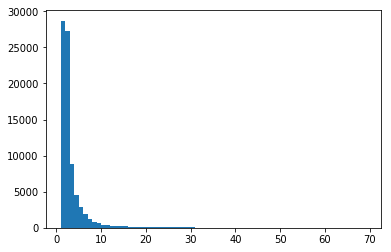

In [27]:
plt.hist(nes, bins=np.arange(1, 70))

In [33]:
elst[0]

'8 * 1 + ( ( 9 + 8 ) / 4 + ( 2 / ( 3 * ( 3 ) ) * 3 ) + 4 / 7 - 1 ) / ( ( ( 1 * 9 ) ) ) / 4 - ( 8 / ( 8 * ( ( 2 ) ) / ( 4 + ( 9 + 5 ) + ( 9 ) / 2 * ( 6 - 8 * 8 ) ) / 5 - ( 9 * 1 / ( 8 * 5 * ( 3 ) ) / ( ( 1 * 8 ) ) + ( 9 + 7 + 7 ) * 9 * 7 ) - 3 * ( 7 + 7 / ( 1 ) / ( 1 ) + ( 3 / ( 4 ) ) ) / 5 * ( ( 3 * 6 * 9 * ( 2 * 8 ) ) ) ) / 3 ) - 4 * 2 / ( 5 / ( 9 - ( ( 2 ) + 5 ) - 9 * ( 1 - 3 / 9 / ( 8 - 6 / 5 ) / 5 ) + 9 + ( 2 - ( 4 ) + 8 / 4 ) / 8 / 7 * ( 2 / 2 + 5 * 2 + 5 * ( 5 + 2 - 8 * ( 1 ) ) / ( 4 - 1 + ( 9 ) + 9 ) - ( ( 8 ) ) / ( 7 - 9 * 9 / ( 4 ) / ( 7 ) * 3 ) ) + ( ( 1 * 8 ) * ( 9 - ( 9 ) + 5 / ( 7 ) - ( 9 / 3 * 3 ) ) ) ) / 4 + ( ( ( ( 7 - 3 / 3 ) * 6 / 9 - 7 / ( ( 6 * 8 / 1 + 5 ) ) ) ) ) )'

In [37]:
len(dslst[0])

346

<BarContainer object of 346 artists>

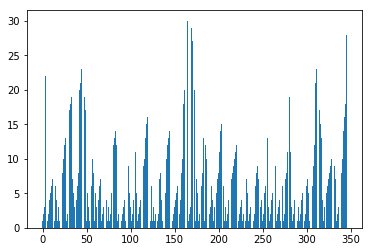

In [36]:
plt.bar(np.arange(len(dslst[0])), dslst[0])